In [6]:
# Define the main path and file paths
main_path = r'D:\Fateme A\23_Brain Electrophysiological Recording during Olfactory Stimulation in Mild Cognitive Impairment and Alzheimer Disease Patients An EEG Dataset'

In [7]:
import os
import numpy as np
import scipy.io
import random

# Define file names
file_paths = {
    "AD": os.path.join(main_path, "AD.mat"),
    "normal": os.path.join(main_path, "normal.mat"),
    "MCI": os.path.join(main_path, "MCI.mat")
}

# Prepare storage per class
class_data = {
    "AD": [],
    "normal": [],
    "MCI": []
}

# Load and organize all trials by class
for label, file_path in file_paths.items():
    mat_data = scipy.io.loadmat(file_path)
    eeg_data = mat_data[label]  # Assuming variable name matches label

    for patient_id in range(eeg_data.shape[1]):  # shape: (1, N_patients)
        patient_data = eeg_data[0][patient_id]
        trials = patient_data[0]  # shape: channels x samples x trials

        # Split into individual trials and add to class list
        for i in range(trials.shape[2]):
            class_data[label].append(trials[:, :, i])  # One trial

# Calculate total trial counts per class
trial_counts = {label: len(trials) for label, trials in class_data.items()}
print("Trial counts per class:", trial_counts)

# Find the minimum number of trials across the 3 classes
min_trial_count = min(trial_counts.values())
print("trial number to balance classes:", min_trial_count)

# Randomly select min_trial_count trials from each class
balanced_data = []
balanced_labels = []

for label in class_data:
    selected_trials = random.sample(class_data[label], min_trial_count)
    balanced_data.extend(selected_trials)
    balanced_labels.extend([label] * min_trial_count)

# Convert to arrays
data_array = np.stack(balanced_data)  # shape: total_trials x channels x samples
labels_array = np.array(balanced_labels)

# Final output info
print("3 * 848 = ", data_array.shape[0])
print('we used random selection of trials to balance classes')

print("Final balanced dataset:")
print("Data shape:", data_array.shape)
print("Labels shape:", labels_array.shape)
print("Labels:", np.unique(labels_array, return_counts=True))


Trial counts per class: {'AD': 1352, 'normal': 1677, 'MCI': 848}
trial number to balance classes: 848
3 * 848 =  2544
we used random selection of trials to balance classes
Final balanced dataset:
Data shape: (2544, 4, 600)
Labels shape: (2544,)
Labels: (array(['AD', 'MCI', 'normal'], dtype='<U6'), array([848, 848, 848]))


## Transfer Entropy Function

In [8]:
import numpy as np
from scipy.stats import entropy
from collections import Counter

def transfer_entropy(source, target, delay=1, bins=10):
    """
    Calculate transfer entropy from source to target time series.
    
    Parameters:
    source: array-like, source time series
    target: array-like, target time series
    delay: int, time delay (default=1)
    bins: int, number of bins for discretization (default=10)
    
    Returns:
    float: transfer entropy value
    """
    # Ensure inputs are numpy arrays
    source = np.array(source)
    target = np.array(target)
    
    # Create discretized versions of the signals
    source_binned = np.digitize(source, np.linspace(min(source), max(source), bins))
    target_binned = np.digitize(target, np.linspace(min(target), max(target), bins))
    
    # Create time-shifted versions
    target_past = target_binned[:-delay]
    target_future = target_binned[delay:]
    source_past = source_binned[:-delay]
    
    # Calculate joint and marginal probabilities
    states = list(zip(target_future, target_past, source_past))
    p_joint = Counter(states)
    total_states = len(states)
    
    # Normalize to get probabilities
    for k in p_joint:
        p_joint[k] = p_joint[k] / total_states
    
    # Calculate conditional states
    states_condition = list(zip(target_past, source_past))
    p_condition = Counter(states_condition)
    for k in p_condition:
        p_condition[k] = p_condition[k] / total_states
    
    states_target = list(zip(target_future, target_past))
    p_target = Counter(states_target)
    for k in p_target:
        p_target[k] = p_target[k] / total_states
    
    # Calculate transfer entropy
    te = 0
    for state in p_joint:
        future, past, source_p = state
        if p_joint[state] > 0:
            dividend = p_joint[state] * p_condition[(past, source_p)]
            divisor = p_target[(future, past)] * p_condition[(past, source_p)]
            if divisor > 0:  # Add check to prevent division by zero
                te += p_joint[state] * np.log2(dividend / divisor)
    
    return te

## Comparing Classifiers

change line 65 for other channels

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt

# === Classifiers ===
classifiers = {
    'SVM': SVC(kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='lbfgs', C=1.0, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Define frequency bands
bands = {
    "delta": (0.1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (30, 40)
}

def bandpass_filter(signal, lowcut=0.1, highcut=40.0, fs=200.0, order=3):
    """Apply a Butterworth bandpass filter to a signal."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# --- Transfer entropy feature extraction for specific bands ---
def extract_transfer_entropy_features_between_bands(trial, band_range_1, band_range_2):
    """
    Extract transfer entropy features between two frequency bands from the same channel.
    trial shape: (channels, samples)
    band_range_1: tuple (low_freq, high_freq) for first band
    band_range_2: tuple (low_freq, high_freq) for second band
    """
    low_freq_1, high_freq_1 = band_range_1
    low_freq_2, high_freq_2 = band_range_2
    
    # Get first channel (can be modified to use different channels)
    ch1 = trial[0, :]
    
    # Filter the same channel for two different frequency bands
    band_1_signal = bandpass_filter(ch1, low_freq_1, high_freq_1, fs=200)
    band_2_signal = bandpass_filter(ch1, low_freq_2, high_freq_2, fs=200)
    
    # Calculate transfer entropy between the filtered band signals
    te_feature = transfer_entropy(band_1_signal, band_2_signal)
    
    return [te_feature]

def process_data_band_to_band_transfer_entropy(data_array, band_range_1, band_range_2):
    """
    Process data array and extract transfer entropy features between two frequency bands.
    data_array: shape (trials, channels, samples)
    band_range_1: tuple (low_freq, high_freq) for source band
    band_range_2: tuple (low_freq, high_freq) for target band
    """
    feature_list = []
    for trial_data in data_array:
        trial_data = np.array(trial_data, dtype=np.float64)
        
        # Extract transfer entropy features between the two bands
        trial_features = extract_transfer_entropy_features_between_bands(trial_data, band_range_1, band_range_2)
        feature_list.append(trial_features)
    
    return np.array(feature_list)

def evaluate_band_to_band_transfer_entropy(data_array, labels_array, band_name_1, band_range_1, band_name_2, band_range_2):
    """
    Evaluate classifiers using transfer entropy features between two frequency bands.
    """
    print(f"\n=== Evaluating Transfer Entropy: {band_name_1.upper()} → {band_name_2.upper()} ===")

    # Extract transfer entropy features between the two bands
    X = process_data_band_to_band_transfer_entropy(data_array, band_range_1, band_range_2)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels_array)

    # Prepare cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    results = {}

    for name, clf in classifiers.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ])

        scores = cross_val_score(pipeline, X, y_encoded, cv=skf, scoring='accuracy')

        results[name] = {
            'Mean Accuracy': np.mean(scores),
            'Std Accuracy': np.std(scores),
            'All Scores': scores
        }

        print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

    return results

def evaluate_all_band_combinations_transfer_entropy(data_array, labels_array):
    """
    Evaluate transfer entropy features for all frequency band combinations.
    """
    print("\n" + "="*80)
    print("EVALUATING TRANSFER ENTROPY BETWEEN ALL FREQUENCY BAND COMBINATIONS")
    print("="*80)
    
    all_results = {}
    
    # Evaluate each band combination (including self-connections and bidirectional)
    for band_name_1, band_range_1 in bands.items():
        for band_name_2, band_range_2 in bands.items():
            if band_name_1 == band_name_2:
                # Skip self-connections (e.g., alpha to alpha)
                continue
            combination_key = f"{band_name_1}_to_{band_name_2}"
            band_results = evaluate_band_to_band_transfer_entropy(
                data_array, labels_array, band_name_1, band_range_1, band_name_2, band_range_2
            )
            all_results[combination_key] = band_results
    
    # Create comprehensive visualization
    create_comprehensive_transfer_entropy_plots(all_results)
    
    # Print summary table
    create_comprehensive_summary_table(all_results)
    
    return all_results

def create_comprehensive_transfer_entropy_plots(all_results):
    """
    Create comprehensive plots comparing transfer entropy performance across band combinations and classifiers.
    """
    # Prepare data for plotting
    plot_data = []
    for combination_name, combination_results in all_results.items():
        source_band, target_band = combination_name.split('_to_')
        for classifier_name, metrics in combination_results.items():
            plot_data.append({
                'Source Band': source_band.title(),
                'Target Band': target_band.title(),
                'Combination': f"{source_band.title()} → {target_band.title()}",
                'Classifier': classifier_name,
                'Mean Accuracy': metrics['Mean Accuracy'],
                'Std Accuracy': metrics['Std Accuracy']
            })
    
    df = pd.DataFrame(plot_data)
    
    # Create comprehensive figure with multiple subplots
    fig = plt.figure(figsize=(24, 16))
    
    # Main title
    fig.suptitle('Transfer Entropy Classification Performance: Band-to-Band Analysis', 
                 fontsize=20, fontweight='bold', y=0.98)
    
    # Create grid layout
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # Plot 1: Overall accuracy heatmap by combination
    ax1 = fig.add_subplot(gs[0, :2])
    pivot_accuracy = df.groupby(['Source Band', 'Target Band'])['Mean Accuracy'].mean().unstack()
    sns.heatmap(pivot_accuracy, annot=True, fmt='.3f', cmap='viridis', ax=ax1, cbar_kws={'label': 'Mean Accuracy'})
    ax1.set_title('Mean Accuracy Heatmap: Source → Target Band Combinations', fontweight='bold')
    ax1.set_xlabel('Target Band')
    ax1.set_ylabel('Source Band')
    
    # Plot 2: Best classifier per combination
    ax2 = fig.add_subplot(gs[0, 2:])
    best_per_combination = df.loc[df.groupby('Combination')['Mean Accuracy'].idxmax()]
    best_per_combination_sorted = best_per_combination.nlargest(15, 'Mean Accuracy')
    
    sns.barplot(data=best_per_combination_sorted, y='Combination', x='Mean Accuracy', 
                hue='Classifier', ax=ax2, palette='Set2')
    ax2.set_title('Top 15 Band Combinations (Best Classifier Each)', fontweight='bold')
    ax2.set_xlabel('Mean Accuracy')
    ax2.set_ylabel('Band Combination')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 3: Classifier performance comparison
    ax3 = fig.add_subplot(gs[1, :2])
    classifier_performance = df.groupby('Classifier')['Mean Accuracy'].agg(['mean', 'std']).reset_index()
    classifier_performance = classifier_performance.sort_values('mean', ascending=True)
    
    bars = ax3.barh(classifier_performance['Classifier'], classifier_performance['mean'], 
                    xerr=classifier_performance['std'], capsize=5, color='skyblue', alpha=0.7)
    ax3.set_title('Average Classifier Performance Across All Band Combinations', fontweight='bold')
    ax3.set_xlabel('Mean Accuracy')
    ax3.set_ylabel('Classifier')
    ax3.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, mean_val) in enumerate(zip(bars, classifier_performance['mean'])):
        ax3.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{mean_val:.3f}', ha='left', va='center', fontweight='bold')
    
    # Plot 4: Source band analysis
    ax4 = fig.add_subplot(gs[1, 2:])
    source_performance = df.groupby('Source Band')['Mean Accuracy'].agg(['mean', 'std']).reset_index()
    source_performance = source_performance.sort_values('mean', ascending=False)
    
    sns.barplot(data=source_performance, x='Source Band', y='mean', ax=ax4, palette='viridis')
    ax4.errorbar(range(len(source_performance)), source_performance['mean'], 
                yerr=source_performance['std'], fmt='none', color='black', capsize=5)
    ax4.set_title('Average Performance by Source Band', fontweight='bold')
    ax4.set_xlabel('Source Band')
    ax4.set_ylabel('Mean Accuracy')
    ax4.grid(axis='y', alpha=0.3)
    
    # Plot 5: Distribution of accuracies
    ax5 = fig.add_subplot(gs[2, :2])
    sns.violinplot(data=df, x='Classifier', y='Mean Accuracy', ax=ax5, palette='Set3')
    ax5.set_title('Distribution of Accuracies by Classifier', fontweight='bold')
    ax5.set_xlabel('Classifier')
    ax5.set_ylabel('Mean Accuracy')
    ax5.tick_params(axis='x', rotation=45)
    
    # Plot 6: Top performing combinations detailed view
    ax6 = fig.add_subplot(gs[2, 2:])
    top_combinations = df.nlargest(20, 'Mean Accuracy')
    
    # Create a scatter plot with different colors for each classifier
    for classifier in top_combinations['Classifier'].unique():
        classifier_data = top_combinations[top_combinations['Classifier'] == classifier]
        ax6.scatter(classifier_data['Mean Accuracy'], classifier_data['Combination'], 
                   label=classifier, alpha=0.7, s=60)
    
    ax6.set_title('Top 20 Performances: Combination vs Accuracy', fontweight='bold')
    ax6.set_xlabel('Mean Accuracy')
    ax6.set_ylabel('Band Combination')
    ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax6.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_comprehensive_summary_table(all_results):
    """
    Create and print a comprehensive summary table for transfer entropy results.
    """
    print("\n" + "="*120)
    print("TRANSFER ENTROPY BETWEEN FREQUENCY BANDS - COMPREHENSIVE SUMMARY")
    print("="*120)
    
    # Create summary dataframe
    summary_data = []
    for combination_name, combination_results in all_results.items():
        source_band, target_band = combination_name.split('_to_')
        for classifier_name, metrics in combination_results.items():
            summary_data.append({
                'Source Band': source_band.title(),
                'Target Band': target_band.title(),
                'Combination': f"{source_band.title()} → {target_band.title()}",
                'Classifier': classifier_name,
                'Mean Accuracy': metrics['Mean Accuracy'],
                'Std Accuracy': metrics['Std Accuracy'],
                'Performance': f"{metrics['Mean Accuracy']:.3f} ± {metrics['Std Accuracy']:.3f}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Print top 20 performances
    print("TOP 20 PERFORMANCES:")
    print("-" * 120)
    top_20 = summary_df.nlargest(20, 'Mean Accuracy')[['Combination', 'Classifier', 'Performance']]
    print(top_20.to_string(index=False))
    
    # Print best performance per band combination
    print("\n" + "="*80)
    print("BEST CLASSIFIER PER BAND COMBINATION:")
    print("="*80)
    
    best_per_combination = summary_df.loc[summary_df.groupby('Combination')['Mean Accuracy'].idxmax()]
    best_per_combination_sorted = best_per_combination.sort_values('Mean Accuracy', ascending=False)
    
    for _, row in best_per_combination_sorted.head(15).iterrows():
        print(f"{row['Combination']:20s}: {row['Classifier']:18s} - {row['Performance']}")
    
    # Print best performance per classifier
    print("\n" + "="*80)
    print("BEST BAND COMBINATION PER CLASSIFIER:")
    print("="*80)
    
    best_per_classifier = summary_df.loc[summary_df.groupby('Classifier')['Mean Accuracy'].idxmax()]
    best_per_classifier_sorted = best_per_classifier.sort_values('Mean Accuracy', ascending=False)
    
    for _, row in best_per_classifier_sorted.iterrows():
        print(f"{row['Classifier']:18s}: {row['Combination']:20s} - {row['Performance']}")
    
    # Print overall statistics
    print("\n" + "="*80)
    print("OVERALL STATISTICS:")
    print("="*80)
    
    overall_best = summary_df.loc[summary_df['Mean Accuracy'].idxmax()]
    print(f"Best Overall Performance: {overall_best['Combination']} with {overall_best['Classifier']} - {overall_best['Performance']}")
    print(f"Average Accuracy Across All Combinations: {summary_df['Mean Accuracy'].mean():.3f} ± {summary_df['Mean Accuracy'].std():.3f}")
    print(f"Median Accuracy: {summary_df['Mean Accuracy'].median():.3f}")
    print(f"Range: {summary_df['Mean Accuracy'].min():.3f} - {summary_df['Mean Accuracy'].max():.3f}")

# --- Legacy functions for backward compatibility ---
def extract_features(trial):
    """
    Legacy function - extract transfer entropy from full bandwidth signals between first two channels.
    trial shape: (channels, samples)
    """
    if trial.shape[0] < 2:
        # If only one channel, use filtered versions of the same channel
        ch1 = trial[0]
        ch2 = bandpass_filter(trial[0], lowcut=8, highcut=14, fs=200)  # Alpha band
    else:
        ch1 = trial[0]
        ch2 = trial[1]
    
    feature = transfer_entropy(ch1, ch2)
    return [feature]

def process_data(data_array, feature_extractor):
    """
    Legacy function - process data using full bandwidth.
    """
    features = []
    for trial in data_array:
        trial = np.array(trial, dtype=np.float64)
        # Apply bandpass filter to entire trial
        if trial.ndim == 2:
            filtered_signal = np.array([bandpass_filter(trial[i], fs=200) for i in range(trial.shape[0])])
        else:
            filtered_signal = bandpass_filter(trial, fs=200)
        feat = feature_extractor(filtered_signal)
        features.append(feat)
    return np.array(features)

def evaluate_features(data_array, labels_array):
    """
    Legacy function - evaluate using full bandwidth transfer entropy.
    """
    print("\n=== Evaluating Transfer Entropy Features (Full Bandwidth) with 10-Fold Cross-Validation ===")

    # Extract features
    X = process_data(data_array, extract_features)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels_array)

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    results = {}
    print("\n=== Classifier Performance (10-fold Accuracy) ===")

    for name, clf in classifiers.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ])

        scores = cross_val_score(pipeline, X, y_encoded, cv=skf, scoring='accuracy')

        results[name] = {
            'Mean Accuracy': np.mean(scores),
            'Std Accuracy': np.std(scores),
            'All Scores': scores
        }

        print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

    # Create improved plot
    create_legacy_performance_plot(results)
    
    return results

def create_legacy_performance_plot(results):
    """
    Create an improved plot for legacy full-bandwidth results.
    """
    accuracy_df = pd.DataFrame({
        'Classifier': list(results.keys()),
        'Mean Accuracy': [results[m]['Mean Accuracy'] for m in results],
        'Std Accuracy': [results[m]['Std Accuracy'] for m in results]
    }).sort_values(by='Mean Accuracy', ascending=False)

    plt.figure(figsize=(12, 8))
    
    # Create bar plot with error bars
    bars = plt.bar(accuracy_df['Classifier'], accuracy_df['Mean Accuracy'], 
                   yerr=accuracy_df['Std Accuracy'], capsize=5, 
                   color='steelblue', alpha=0.7, edgecolor='navy')

    # Add value labels on bars
    for bar, (_, row) in zip(bars, accuracy_df.iterrows()):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + row['Std Accuracy'] + 0.01,
                f'{row["Mean Accuracy"]:.3f}±{row["Std Accuracy"]:.3f}', 
                ha='center', va='bottom', fontweight='bold')

    plt.title("10-Fold Cross-Validated Accuracy using Transfer Entropy Features\n(Full Bandwidth Analysis)", 
              fontsize=14, fontweight='bold')
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel("Classifier", fontsize=12)
    plt.ylim(0, min(1.0, accuracy_df['Mean Accuracy'].max() + accuracy_df['Std Accuracy'].max() + 0.1))
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# USAGE EXAMPLES:
# ============================================================================

print("Transfer Entropy Band Analysis Functions Ready!")
print("\nAvailable Functions:")
print("="*50)
print("1. evaluate_all_band_combinations_transfer_entropy(data_array, labels_array)")
print("   - Analyzes transfer entropy between ALL frequency band combinations")
print("   - Includes comprehensive visualizations and summary tables")
print("")
print("2. evaluate_features(data_array, labels_array)")
print("   - Legacy full bandwidth analysis")
print("   - Uses transfer entropy between channels or filtered versions")
print("")
print("3. evaluate_band_to_band_transfer_entropy(data_array, labels_array, 'alpha', (8, 14), 'beta', (14, 30))")
print("   - Analyzes specific band-to-band transfer entropy")
print("")
print("Required data format:")
print("- data_array: shape (trials, channels, samples)")
print("- labels_array: shape (trials,)")
print("")
print("Note: The transfer_entropy(x, y) function is included as a placeholder.")
print("      Replace it with your actual transfer entropy implementation!")
print("")
print("Example usage:")
print("results = evaluate_all_band_combinations_transfer_entropy(data_array, labels_array)")

Transfer Entropy Band Analysis Functions Ready!

Available Functions:
1. evaluate_all_band_combinations_transfer_entropy(data_array, labels_array)
   - Analyzes transfer entropy between ALL frequency band combinations
   - Includes comprehensive visualizations and summary tables

2. evaluate_features(data_array, labels_array)
   - Legacy full bandwidth analysis
   - Uses transfer entropy between channels or filtered versions

3. evaluate_band_to_band_transfer_entropy(data_array, labels_array, 'alpha', (8, 14), 'beta', (14, 30))
   - Analyzes specific band-to-band transfer entropy

Required data format:
- data_array: shape (trials, channels, samples)
- labels_array: shape (trials,)

Note: The transfer_entropy(x, y) function is included as a placeholder.
      Replace it with your actual transfer entropy implementation!

Example usage:
results = evaluate_all_band_combinations_transfer_entropy(data_array, labels_array)



EVALUATING TRANSFER ENTROPY BETWEEN ALL FREQUENCY BAND COMBINATIONS

=== Evaluating Transfer Entropy: DELTA → THETA ===
SVM: 0.346 ± 0.022
Random Forest: 0.341 ± 0.020
Naive Bayes: 0.346 ± 0.013
Logistic Regression: 0.347 ± 0.024
Decision Tree: 0.341 ± 0.019

=== Evaluating Transfer Entropy: DELTA → ALPHA ===
SVM: 0.381 ± 0.021
Random Forest: 0.360 ± 0.026
Naive Bayes: 0.353 ± 0.020
Logistic Regression: 0.364 ± 0.030
Decision Tree: 0.357 ± 0.026

=== Evaluating Transfer Entropy: DELTA → BETA ===
SVM: 0.375 ± 0.018
Random Forest: 0.316 ± 0.029
Naive Bayes: 0.345 ± 0.020
Logistic Regression: 0.353 ± 0.018
Decision Tree: 0.318 ± 0.029

=== Evaluating Transfer Entropy: DELTA → GAMMA ===
SVM: 0.363 ± 0.021
Random Forest: 0.325 ± 0.035
Naive Bayes: 0.343 ± 0.008
Logistic Regression: 0.332 ± 0.013
Decision Tree: 0.325 ± 0.032

=== Evaluating Transfer Entropy: THETA → DELTA ===
SVM: 0.346 ± 0.022
Random Forest: 0.341 ± 0.020
Naive Bayes: 0.346 ± 0.013
Logistic Regression: 0.347 ± 0.024
Decisi

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5252\3081979008.py:231: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=source_performance, x='Source Band', y='mean', ax=ax4, palette='viridis')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5252\3081979008.py:241: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Classifier', y='Mean Accuracy', ax=ax5, palette='Set3')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5252\3081979008.py:263: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


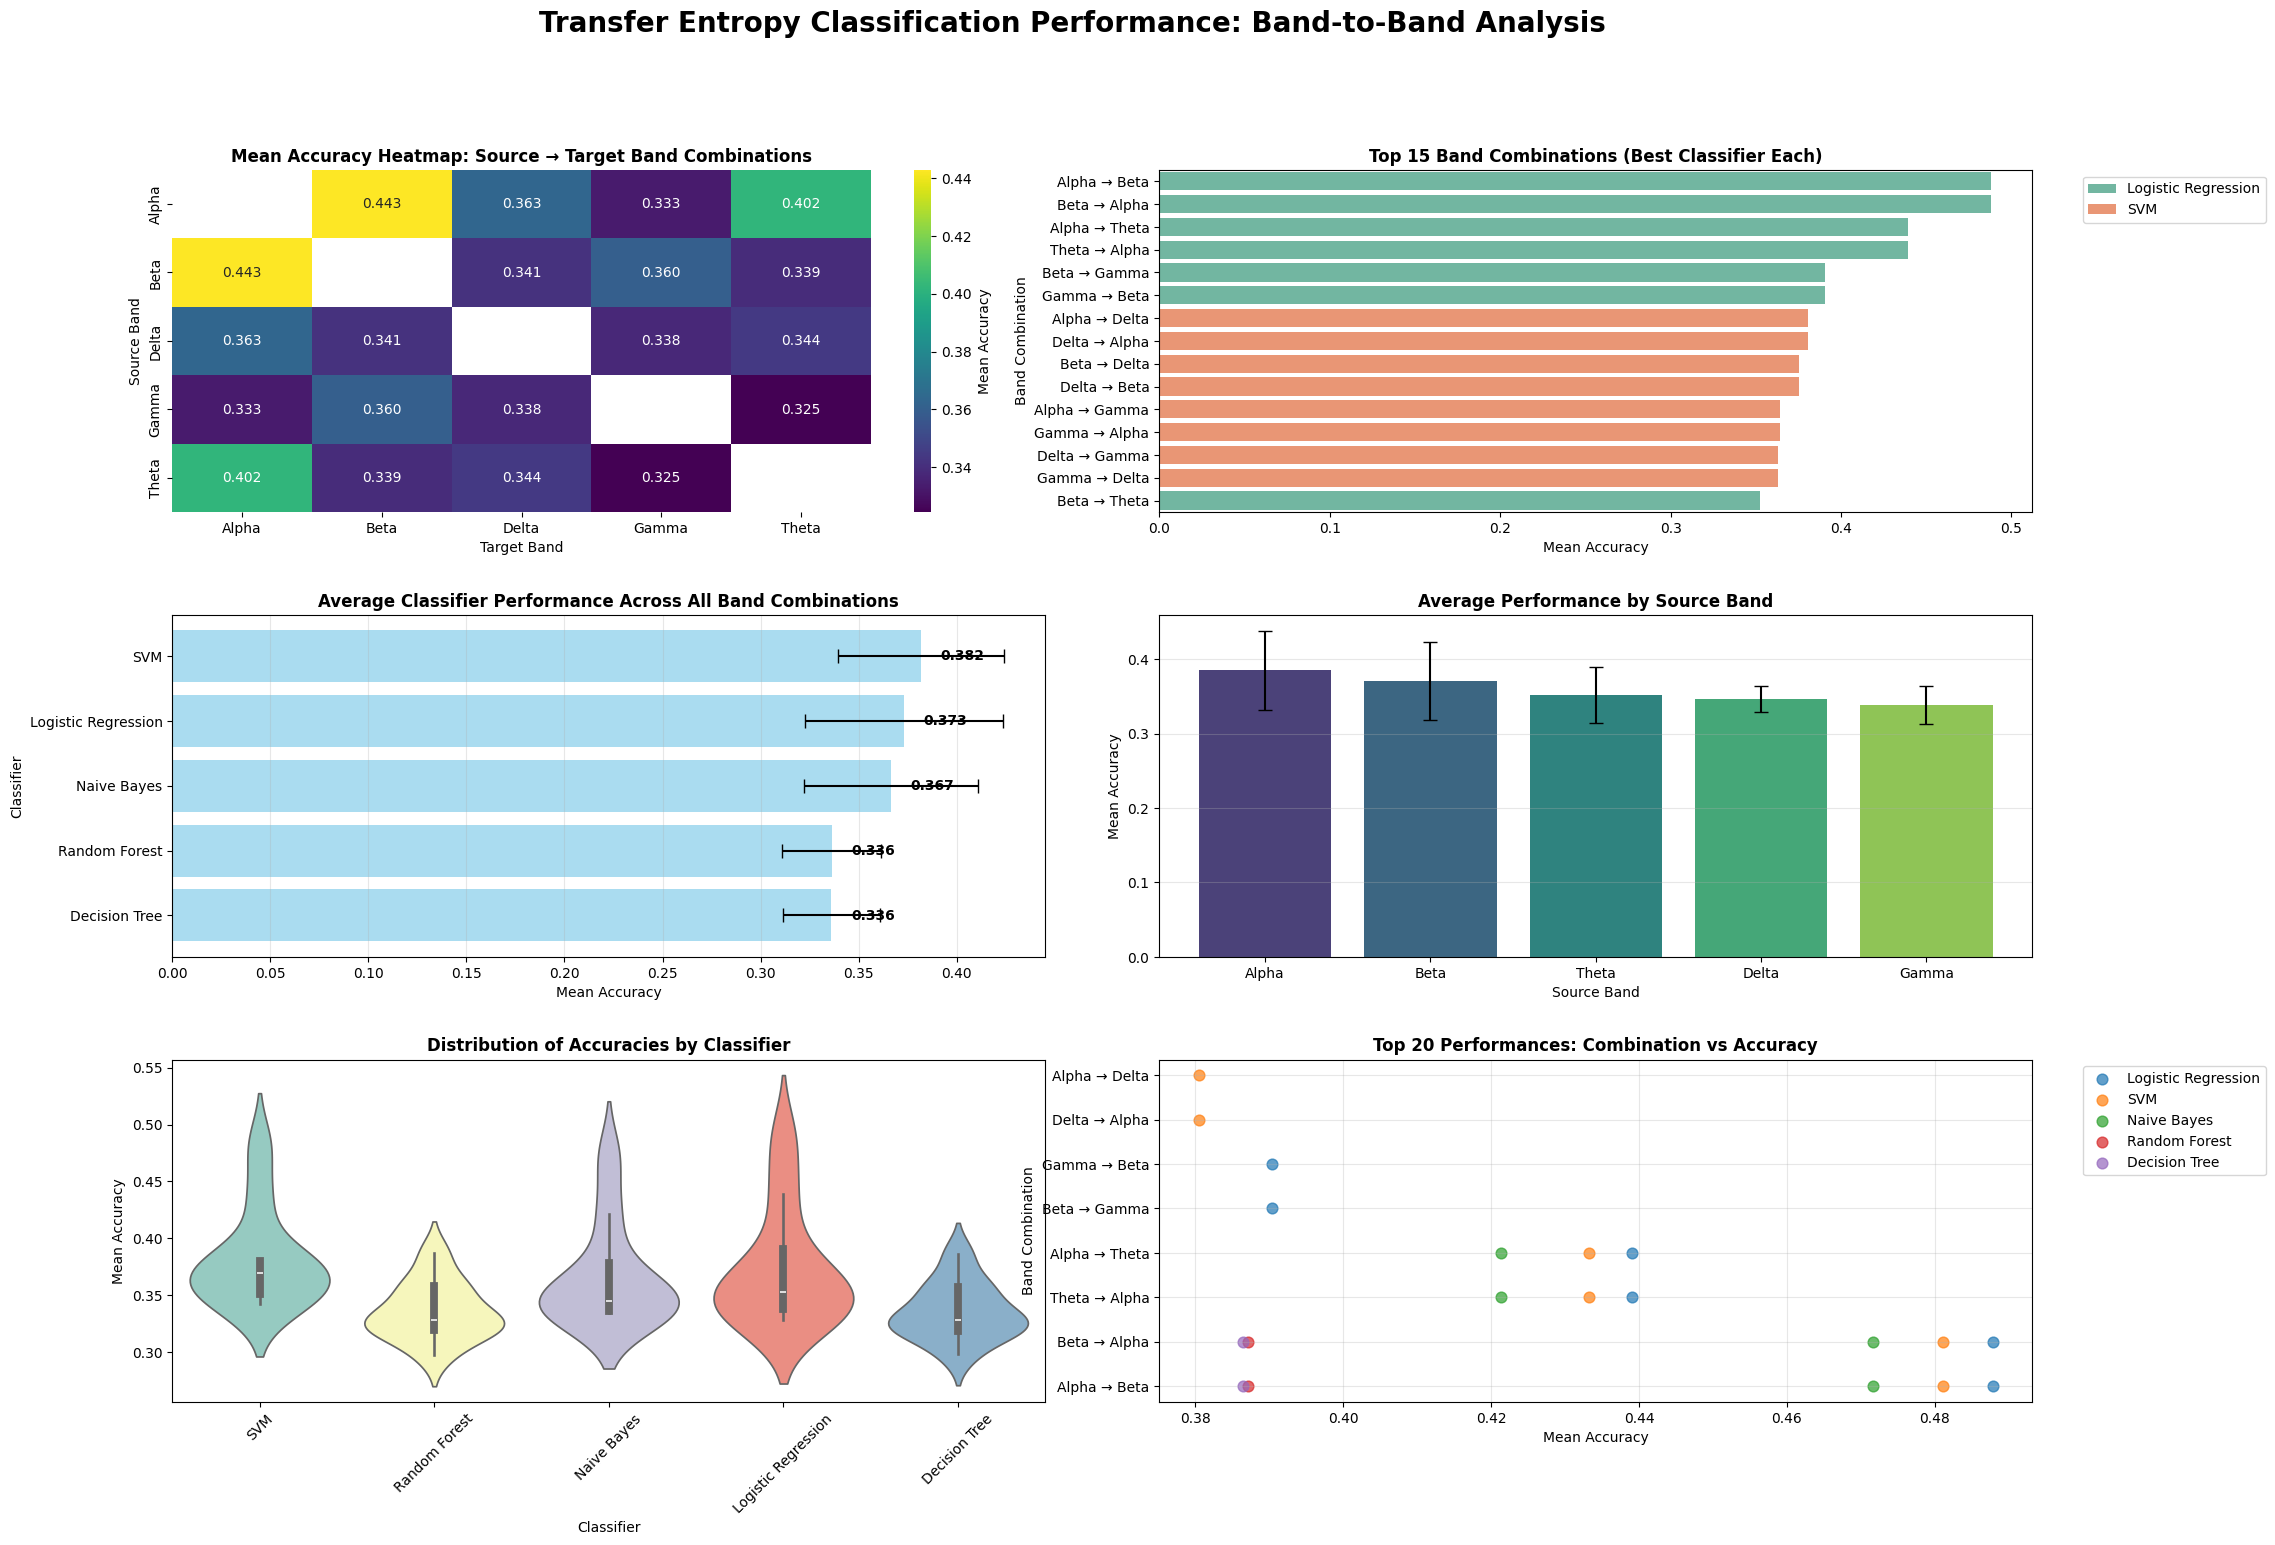


TRANSFER ENTROPY BETWEEN FREQUENCY BANDS - COMPREHENSIVE SUMMARY
TOP 20 PERFORMANCES:
------------------------------------------------------------------------------------------------------------------------
  Combination          Classifier   Performance
 Alpha → Beta Logistic Regression 0.488 ± 0.026
 Beta → Alpha Logistic Regression 0.488 ± 0.026
 Alpha → Beta                 SVM 0.481 ± 0.023
 Beta → Alpha                 SVM 0.481 ± 0.023
 Alpha → Beta         Naive Bayes 0.472 ± 0.027
 Beta → Alpha         Naive Bayes 0.472 ± 0.027
Theta → Alpha Logistic Regression 0.439 ± 0.034
Alpha → Theta Logistic Regression 0.439 ± 0.034
Theta → Alpha                 SVM 0.433 ± 0.024
Alpha → Theta                 SVM 0.433 ± 0.024
Theta → Alpha         Naive Bayes 0.421 ± 0.041
Alpha → Theta         Naive Bayes 0.421 ± 0.041
 Beta → Gamma Logistic Regression 0.390 ± 0.039
 Gamma → Beta Logistic Regression 0.390 ± 0.039
 Alpha → Beta       Random Forest 0.387 ± 0.021
 Beta → Alpha       Rand

{'delta_to_theta': {'SVM': {'Mean Accuracy': np.float64(0.3462961247491122),
   'Std Accuracy': np.float64(0.02184997738807882),
   'All Scores': array([0.35294118, 0.3254902 , 0.36078431, 0.36862745, 0.38976378,
          0.31102362, 0.34251969, 0.34645669, 0.33858268, 0.32677165])},
  'Random Forest': {'Mean Accuracy': np.float64(0.3412027173073954),
   'Std Accuracy': np.float64(0.020461496705244785),
   'All Scores': array([0.32156863, 0.36470588, 0.3254902 , 0.33333333, 0.33464567,
          0.35826772, 0.3503937 , 0.30708661, 0.37795276, 0.33858268])},
  'Naive Bayes': {'Mean Accuracy': np.float64(0.34550872317430903),
   'Std Accuracy': np.float64(0.01339708574163266),
   'All Scores': array([0.34509804, 0.36862745, 0.34901961, 0.34509804, 0.34645669,
          0.32677165, 0.32677165, 0.35826772, 0.35826772, 0.33070866])},
  'Logistic Regression': {'Mean Accuracy': np.float64(0.3466728423652925),
   'Std Accuracy': np.float64(0.024292488525907176),
   'All Scores': array([0.3843

In [16]:
# usage:
evaluate_all_band_combinations_transfer_entropy(data_array, labels_array)